<a href="https://colab.research.google.com/github/jhenderson0/jh_ucl_HPC/blob/main/Task%202/JH_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Solving two 1D problems



In [3]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-notebook')

### Part 1: Solving a wave problem with sparse matrices
In this part of the assignment, we want to compute the solution to the following (time-harmonic) wave problem:

$$
\begin{align*}
\frac{\mathrm{d}^2 u}{\mathrm{d}x^2} + k^2u &= 0&&\text{in }(0, 1),\\
u &= 0&&\text{if }x=0,\\
u &= 1&&\text{if }x=1,\\
\end{align*}
$$
with wavenumber $k=29\mathrm{\pi}/2$.

In this part, we will approximately solving this problem using the method of finite differences.
We do this by taking an evenly spaced values
$x_0=0, x_1, x_2, ..., x_N=1$
and approximating the value of $u$ for each value: we will call these approximations $u_i$.
To compute these approximations, we use the approximation

$$
\frac{\mathrm{d}^2u_{i}}{\mathrm{d}x^2} \approx \frac{
u_{i-1}-2u_i+u_{i+1}
}{h^2},
$$
where $h = 1/N$.

With a bit of algebra, we see that the wave problem can be written as

$$
(2-h^2k^2)u_i-u_{i-1}-u_{i+1} = 0
$$
if $x_i$ is not 0 or 1, and

$$
\begin{align*}
u_i &= 0
&&\text{if }x_i=0,\\
u_i &= 1
&&\text{if }x_i=1.
\end{align*}
$$

This information can be used to re-write the problem as the matrix-vector problem
$\mathrm{A}\mathbf{u}=\mathbf{f},$
where $\mathrm{A}$ is a known matrix, $\mathbf{f}$ is a known vector, and $\mathbf{u}$ is an unknown vector that we want to compute.
The entries of 
$\mathbf{f}$ and $\mathbf{u}$ are given by

$$
\begin{align*}
\left[\mathbf{u}\right]_i &= u_i,\\
\left[\mathbf{f}\right]_i &= \begin{cases}
1&\text{if }i=N,\\
0&\text{otherwise}.
\end{cases}
\end{align*}
$$
The rows of $\mathrm{A}$ are given by

$$
\left[\mathrm{A}\right]_{i,j} = 
\begin{cases}
1&\text{if }i=j,\\
0&\text{otherwise},
\end{cases}
$$
if $i=0$ or $i=N$; and

$$
\left[\mathrm{A}\right]_{i, j} = 
\begin{cases}
2-h^2k^2&\text{if }j=i,\\
-1&\text{if }j=i+1,\\
-1&\text{if }j=i-1.\\
0&\text{otherwise},
\end{cases}
$$
otherwise.

### a)

**Write a Python function that takes $N$ as an input and returns the matrix $\mathrm{A}$ and vector $\mathrm{f}$**.
You should use an appropriate sparse storage format for the matrix $\mathrm{A}$.

In [4]:
from scipy.sparse import coo_matrix

In [5]:
def discretise_wave(N):
    """Generate the matrix and rhs associated with the discrete time-harmonic wave equation."""
    
    h = 1/N
    k = 29*np.pi/2

    #Number of elements is N+1 for diagonal + the off diagonal (2N) - the two zeros on the top and bottom row
    nelements = N+1 + 2*N - 2

    #Set up coo styled data storage 
    row_ind = np.zeros(nelements, dtype=int)
    col_ind = np.zeros(nelements, dtype=int)
    data = np.zeros(nelements, dtype=np.float64)
    
    #Create the vector (all zeros with a 1 at the end)
    f = np.concatenate((np.zeros(N, dtype=np.float64),[1]))
    
    #Loop through each row
    count = 0
    for i in range(N+1):
      if i == 0 or i == N:
        
        #For the [0,0] entry and then [N,N] entry we have 1s
        row_ind[count] = col_ind[count] = i
        data[count] =  1
        
        count += 1

      else:
        
        #For each row we have three data entries
        row_ind[count : count+3] = i

        #For the diagonals we have 2-h^2k^2
        col_ind[count] = i
        data[count] = 2-h**2*k**2

        #For the off diagonals we have -1
        col_ind[count + 1] = i + 1
        col_ind[count + 2] = i - 1
        data[count + 1 : count + 3] = -1

        count += 3

    
    return coo_matrix((data, (row_ind, col_ind)), shape=(N+1, N+1)).tocsr(), f

A quick example, if we use N = 2 we expect to get a matrix out which looks like:

$$\mathrm{A} = \begin{bmatrix}
 1& 0 & 0 \\ 
 -1& 2-h^2k^2 & -1 \\ 
0 & 0 & 1
\end{bmatrix}$$

And our vector should be:


$$\mathbf{f} = \begin{bmatrix}
 0 \\ 
 0 \\ 
  1
\end{bmatrix}$$

In [6]:
A, f = discretise_wave(2)
print(A.toarray())
print(f)

[[   1.            0.            0.        ]
 [  -1.         -516.77108133   -1.        ]
 [   0.            0.            1.        ]]
[0. 0. 1.]


### b)

The function `scipy.sparse.linalg.spsolve` can be used to solve a sparse matrix-vector problem. Use this to **compute
the approximate solution for your problem for $N=10$, $N=100$, and $N=1000$**. Use `matplotlib` (or any other plotting library)
to **plot the solutions for these three values of $N$**.

In [7]:
from scipy.sparse.linalg import spsolve

In [8]:
sols = []

Ns = [10,100,1000]

for N in Ns:
  
  A, f = discretise_wave(N)
  sols.append(spsolve(A, f))

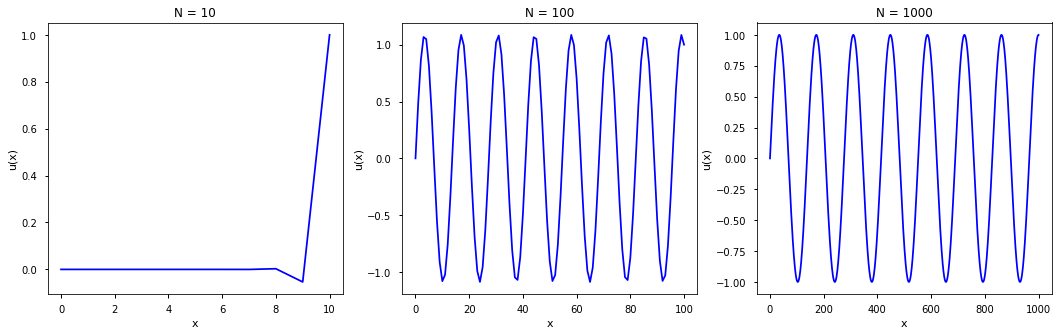

In [9]:
fig, ax = plt.subplots(1,3,figsize=(18, 5))


for idx, N in enumerate(Ns):
  ax[idx].plot(sols[idx],c='b')
  ax[idx].set_ylabel("u(x)")
  ax[idx].set_xlabel("x")
  ax[idx].set_title(f"N = {N}")

### c)

**Briefly (1-2 sentences) comment on your plots**: How different are they to each other? Which do you expect to be closest to the
actual solution of the wave problem?

**Answer** - The greater the value of N used the smoother the function becomes and the closer I would expect it to be to the true analytical solutions.

### d)

This wave problem was carefully chosen so that its exact solution is known: this solution is
$u_\text{exact}(x) = \sin(kx)$. (You can check this by differentiating this twice and substituting, but you
do not need to do this part of this assignment.)

A possible approximate measure of the error in your solution can be found by computing

$$
\max_i\left|u_i-u_\text{exact}(x_i)\right|.
$$
**Compute this error for a range of values for $N$ of your choice, for the methods you wrote in both parts 1 and 2**. On axes that both use log scales,
**plot $N$ against the error in your solution**. You should pick a range of values for $N$ so that this plot will give you useful information about the
methods.

In [10]:
def exact(x):

  k = 29*np.pi/2
  
  return np.sin(k*x)

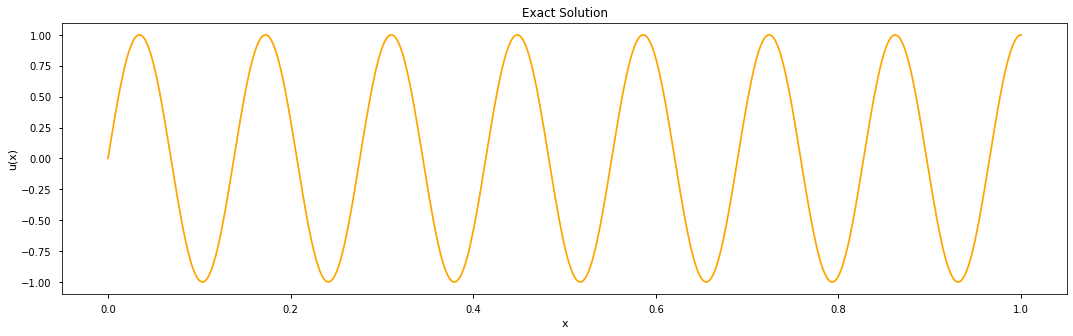

In [11]:
fig, ax = plt.subplots(1,figsize=(18, 5))
x = np.linspace(0,1,1001)
ax.plot(x,exact(x),c='orange')
ax.set_ylabel("u(x)")
ax.set_xlabel("x")
ax.set_title("Exact Solution");

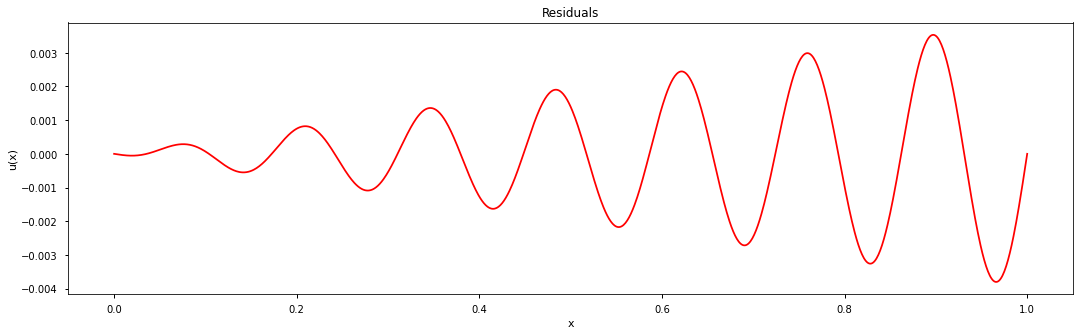

In [12]:
fig, ax = plt.subplots(1,figsize=(18, 5))
x = np.linspace(0,1,1001)
ax.plot(x,exact(x)-sols[2],c='red')
ax.set_ylabel("u(x)")
ax.set_xlabel("x")
ax.set_title("Residuals");

In [13]:
def err(u,u_exact):
  
  return np.amax(np.absolute(u-u_exact))

In [14]:
Ns = np.linspace(100,10000,500,dtype=int)
errs = np.zeros(len(Ns))
for idx, N in enumerate(Ns):
  
  #Solve the equations
  A, f = discretise_wave(N)
  sol = spsolve(A, f)
  
  #Calcualte the exact value
  ex = exact(np.linspace(0,1,N+1))

  #Calcualte the error
  errs[idx] = err(sol,ex)

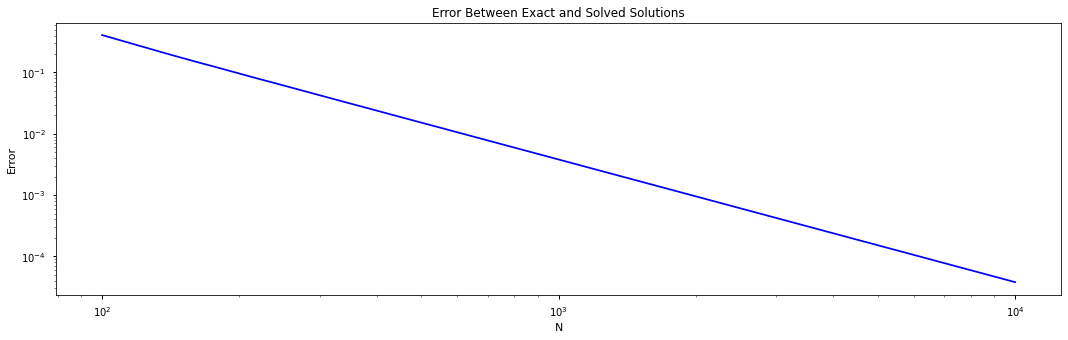

In [15]:
fig, ax = plt.subplots(1,figsize=(18, 5))
ax.plot(Ns,errs,c='b')
ax.set_ylabel("Error")
ax.set_xlabel("N")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Error Between Exact and Solved Solutions");

### e)

For the same values of $N$, **measure the time taken to compute your approximations for both functions**. On axes that both use log scales,
**plot $N$ against the time taken to compute a solution**.

In [16]:
from time import time

In [17]:
Ns = np.linspace(10,10000,500,dtype=int)
times = np.zeros((2,len(Ns)))
for idx, N in enumerate(Ns):
  
  #Solve the equations
  start = time()
  A, f = discretise_wave(N)
  spsolve(A, f)
  times[0,idx] = time() - start
  
  #Calculate the exact value
  start = time()
  exact(np.linspace(0,1,N+1))
  times[1,idx] = time() - start

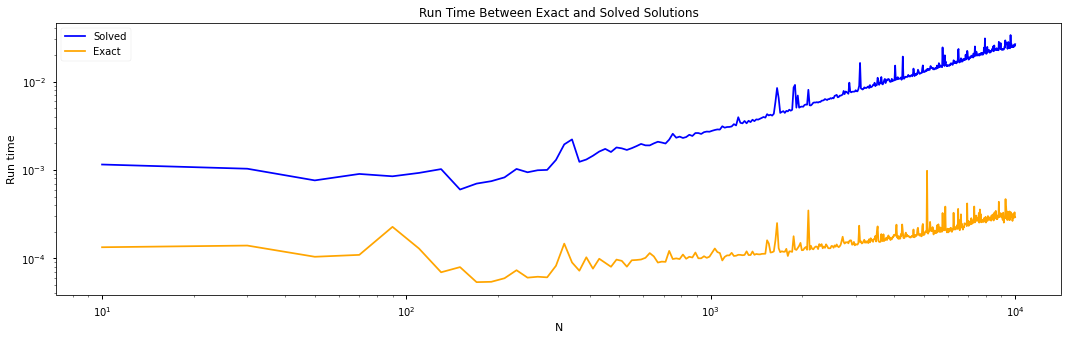

In [18]:
fig, ax = plt.subplots(1,figsize=(18, 5))
ax.plot(Ns,times[0],label = "Solved",c='blue')
ax.plot(Ns,times[1] , label = "Exact",c='orange')
ax.set_ylabel("Run time")
ax.set_xlabel("N")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Run Time Between Exact and Solved Solutions")
ax.legend();

### f)

We now want to compute an approximate solution where the measure of error is $10^{-8}$ or less. By looking at your plots, **pick a value of $N$
that you would expect to give error of $10^{-8}$ or less**. **Briefly (1-2 sentences) explain how you picked your value of $N$
and predict how long the computation will take**.

 **Answer** - I would choose a value in the order of maginutude $\approx 10^6$. This is because the order of maginutude of the error roughly decreases linearly with the order of magnitude of N such that:

$$\log(\text{Err}(N)) \approx -\frac{1}{2}\log(N) + c$$
 
As for run time it seems like this is linked to N roughly by:

$$\log(\text{Time}(N)) \approx \log(N) + c$$

So I would expect a run time around order of maginutude $10^0$ seconds  

### g)

**Compute the approximate solution with your value of $N$**. Measure the time taken and the error, and **briefly (1-2 sentences) comment
on how these compare to your predictions**.

In [19]:
N = int(1e6)

#Solve the equations
start = time()
A, f = discretise_wave(N)
sol = spsolve(A, f)
run_time = time() - start
  
#Calculate the exact value
ex = exact(np.linspace(0,1,N+1))

#Calculate the error
er = err(sol,ex)

In [20]:
print(f"Error: {er}")
print(f"Runtime: {run_time}")

Error: 1.5517885523438912e-08
Runtime: 2.431647539138794


 **Answer** - 

### Part 2: Solving the heat equation with GPU acceleration

In this part of the assignment, we want to solve the heat equation

$$
\begin{align*}
\frac{\mathrm{d}u}{\mathrm{d}t} &= \frac{1}{1000}\frac{\mathrm{d}^2u}{\mathrm{d}x^2}&&\text{for }x\in(0,1),\\
u(x, 0) &= 0,\\
u(0,t) &= 10,\\
u(1,t) &= 10.
\end{align*}
$$
This represents a rod that starts at 0 temperature which is heated to a temperature of 10 at both ends.

Again, we will approximately solve this by taking an evenly spaced values
$x_0=0, x_1, x_2, ..., x_N=1$.
Additionally, we will take a set of evenly spaced times
$t_0=0,t_1=h, t_2=2h, t_3=3h, ...$, where $h=1/N$.
We will write $u^{(j)}_{i}$ for the approximate value of $u$ at point $x_i$ and time $t_j$
(ie $u^{(j)}_{i}\approx u(x_i, t_j)$).

Approximating both derivatives (similar to what we did in part 1), and doing some algebra, we can rewrite the
heat equation as

$$
\begin{align*}
u^{(j + 1)}_i&=u^{(j)}_i + \frac{u^{(j)}_{i-1}-2u^{(j)}_i+u^{(j)}_{i+1}}{1000h},\\
u^{(0)}_i &= 0,\\
u^{(j)}_{0}&=10,\\
u^{(j)}_{N}&=10.
\end{align*}
$$

This leads us to an iterative method for solving this problem: first, at $t=0$, we set

$$
u^{(0)}_i =
\begin{cases}
10 &\text{if }i=0\text{ or }i=N,\\
0 &\text{otherwise};
\end{cases}
$$
then for all later values of time, we set

$$
u^{(j+1)}_i =
\begin{cases}
10 &\text{if }x=0\text{ or }x=N,\\
\displaystyle u^{(j)}_i + \frac{u^{(j)}_{i-1}-2u^{(j)}_i+u^{(j)}_{i+1}}{1000h} &\text{otherwise}.
\end{cases}
$$

### a)

**Implement this iterative scheme in Python**. You should implement this as a function that takes $N$ as an input.

In [21]:
def solve_heat(N,tmax,u):
  #Update the points in the rod excluding the end points

  #Loop through times
  for j in range((N+1)*tmax-1):
    #Update the positions
    u[j+1,1:N] = u[j,1:N] + (u[j,0:N-1] - 2*u[j,1:N] + u[j,2:N+1])* N/1000

In [22]:
N = 3
tmax = 1

#Create the rod and set the ends to a constant temperature
u = np.zeros(((N+1)*tmax,N+1))
u[:,0] = 10
u[:,-1] = 10

solve_heat(N,tmax,u)
u

array([[10.        ,  0.        ,  0.        , 10.        ],
       [10.        ,  0.03      ,  0.03      , 10.        ],
       [10.        ,  0.05991   ,  0.05991   , 10.        ],
       [10.        ,  0.08973027,  0.08973027, 10.        ]])

### b)

Using a sensible value of $N$, **plot the temperature of the rod at $t=1$, $t=2$ and $t=10$**. **Briefly (1-2 sentences)
comment on how you picked a value for $N$**.

In [23]:
N = 500
tmax = 10

#Create the rod and set the ends to a constant temperature
u = np.zeros(((N+1)*tmax,N+1))
u[:,0] = 10
u[:,-1] = 10

solve_heat(N,tmax,u)

Below is a plot showing the temperature across the rod for different time values:

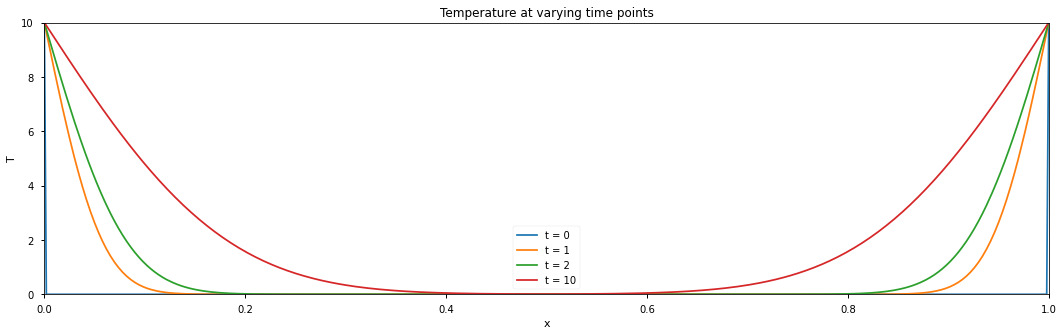

In [24]:
fig, ax = plt.subplots(1,figsize=(18, 5))

ts = [0,1,2,10]
for t in ts:
  ax.plot(np.linspace(0,1,N+1),u[int(t*N)],label=f't = {t}')

ax.set_ylabel("T")
ax.set_xlabel("x")
ax.set_xlim([0,1])
ax.set_ylim([0,10])
ax.set_title("Temperature at varying time points")
ax.legend();

A nice visulisation of the rod:

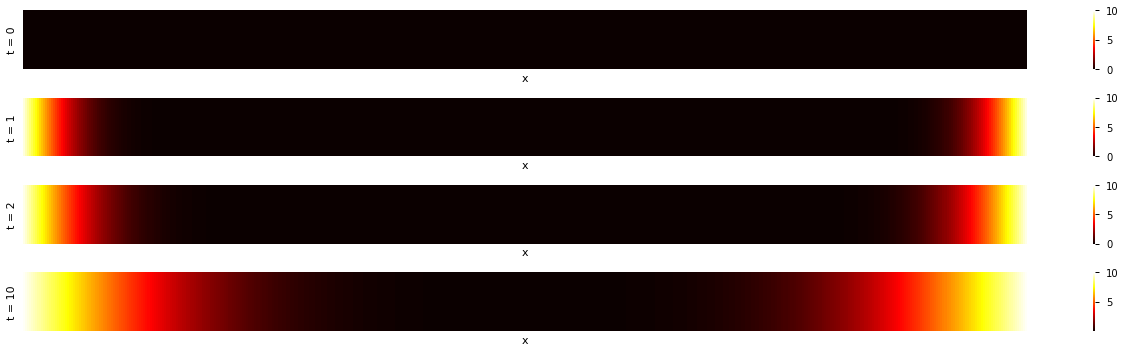

In [25]:
fig, ax = plt.subplots(4,1,figsize=(18, 5))
for idx,t in enumerate(ts):
  sns.heatmap(u[int(t*N)][np.newaxis,:], cmap='hot',ax=ax[idx])
  ax[idx].set_xlabel("x")
  ax[idx].set_ylabel(f"t = {t}")
  ax[idx].set_yticks([])
  ax[idx].set_xticks([])
fig.tight_layout()

In [26]:
import time
from IPython import display

KeyboardInterrupt: ignored

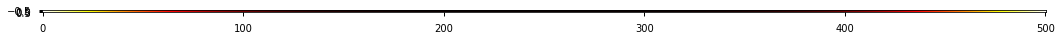

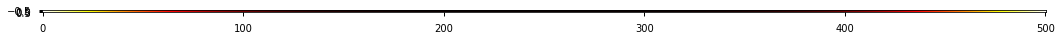

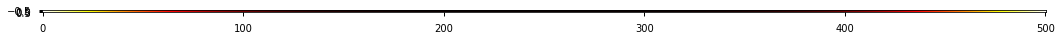

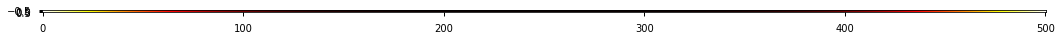

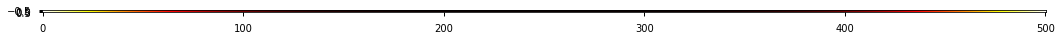

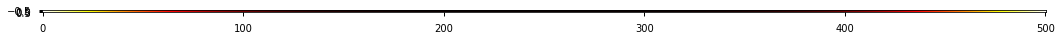

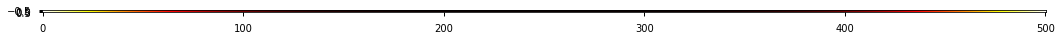

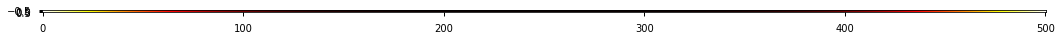

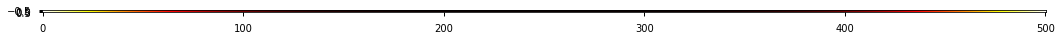

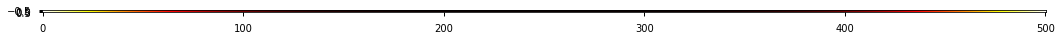

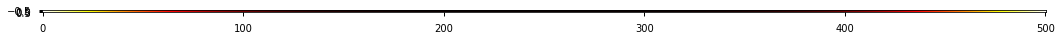

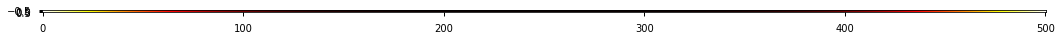

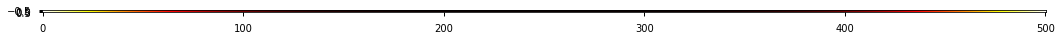

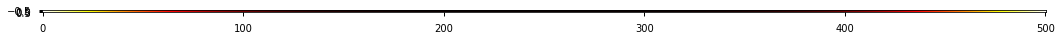

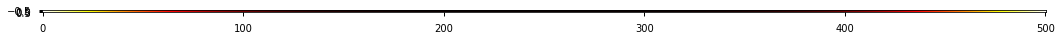

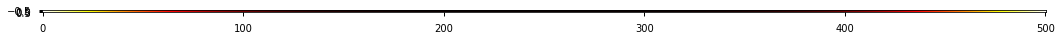

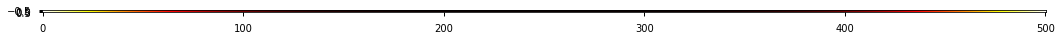

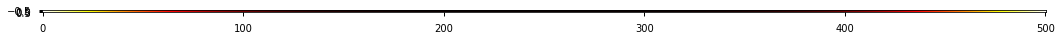

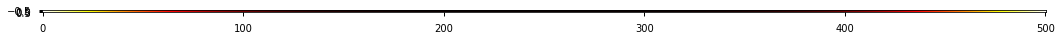

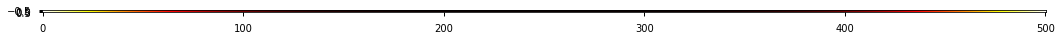

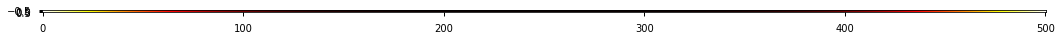

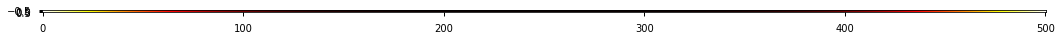

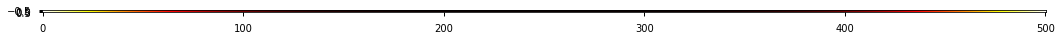

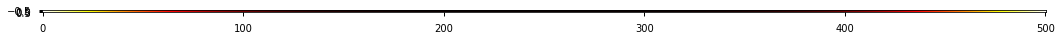

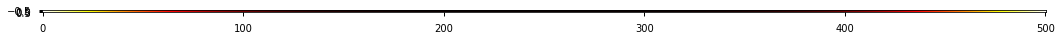

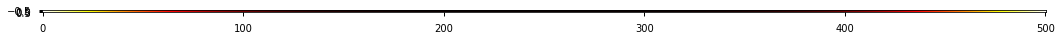

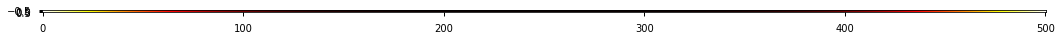

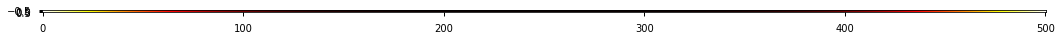

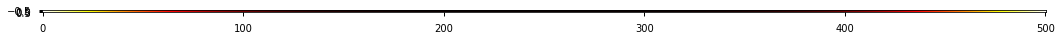

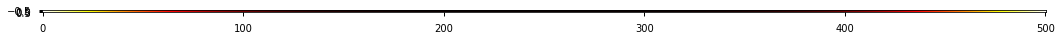

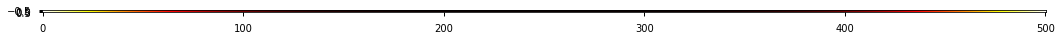

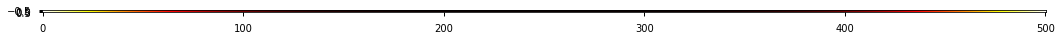

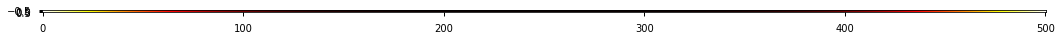

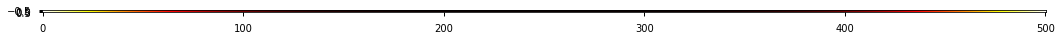

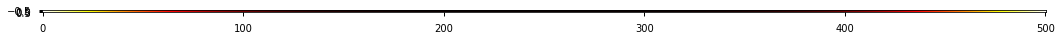

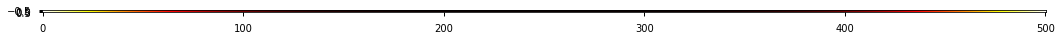

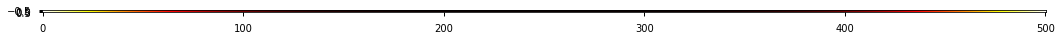

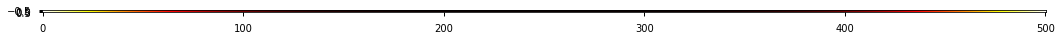

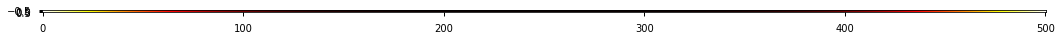

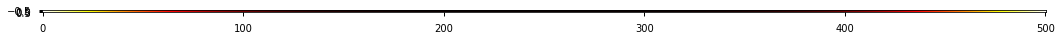

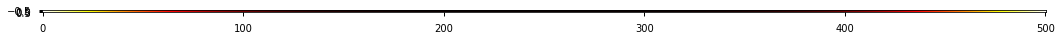

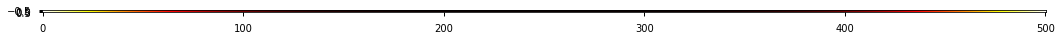

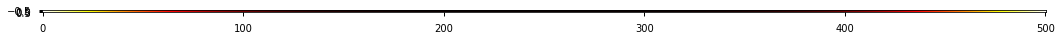

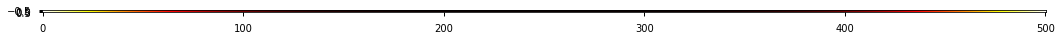

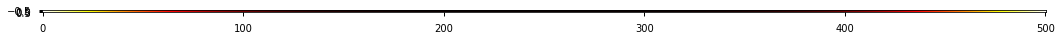

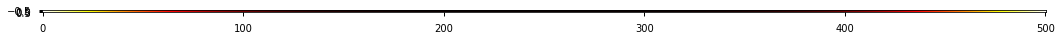

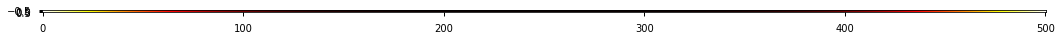

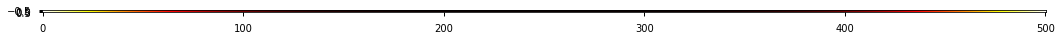

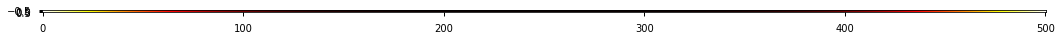

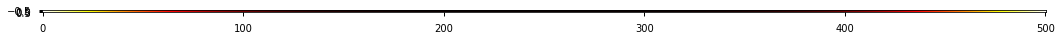

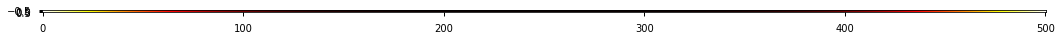

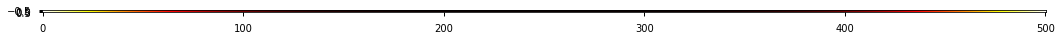

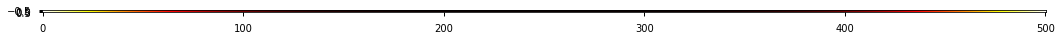

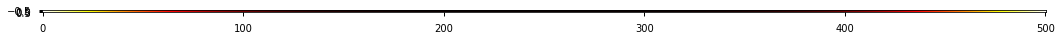

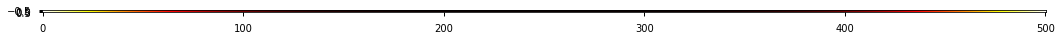

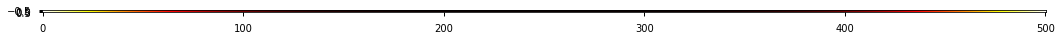

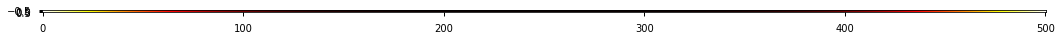

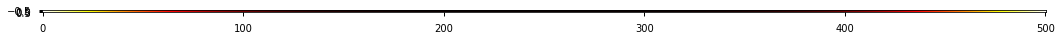

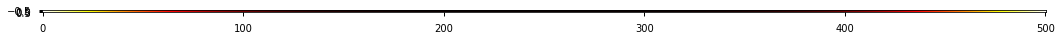

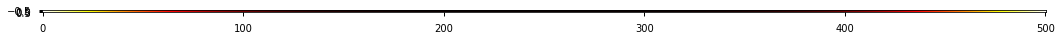

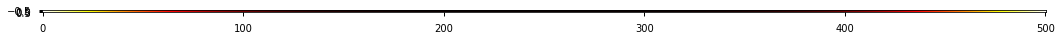

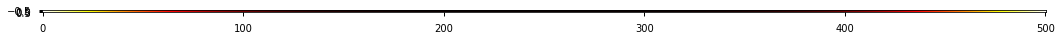

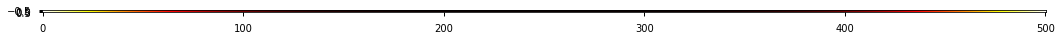

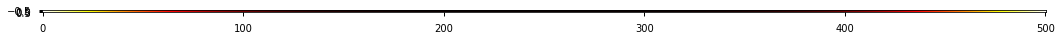

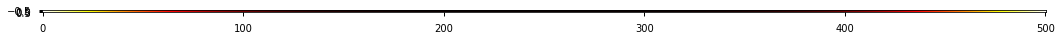

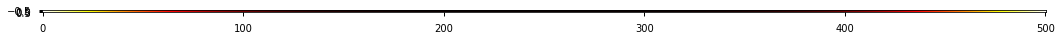

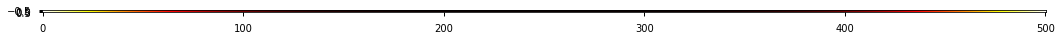

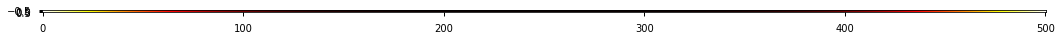

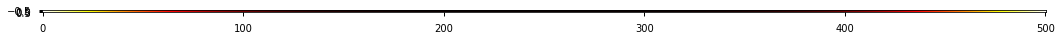

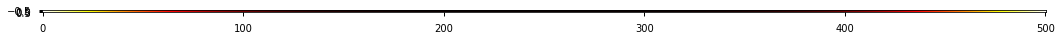

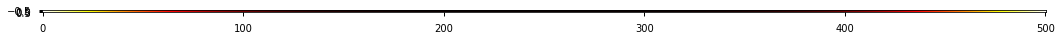

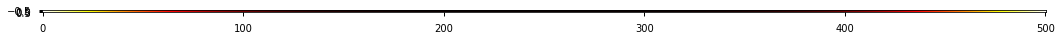

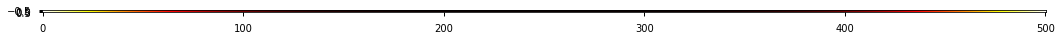

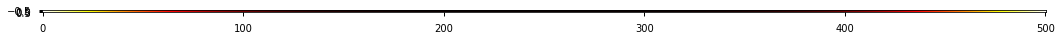

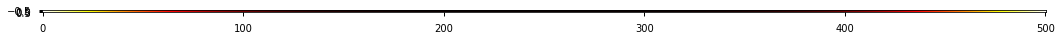

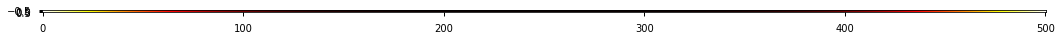

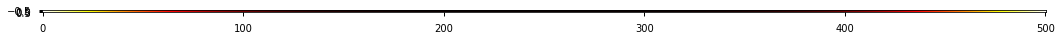

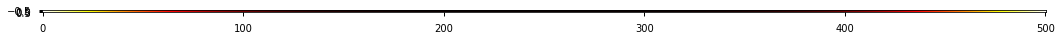

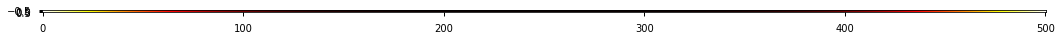

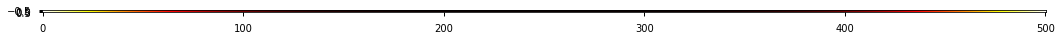

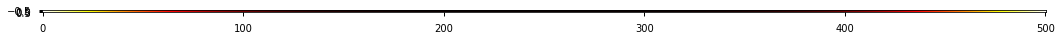

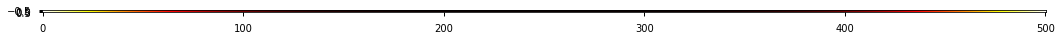

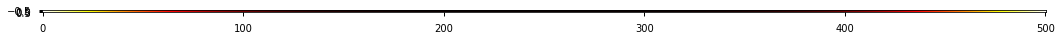

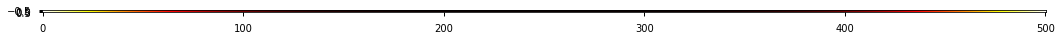

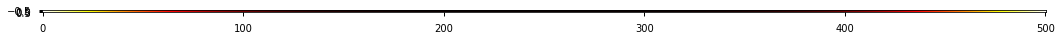

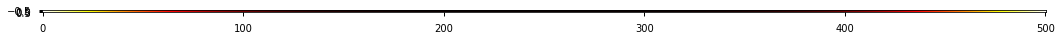

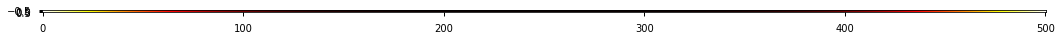

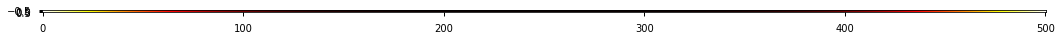

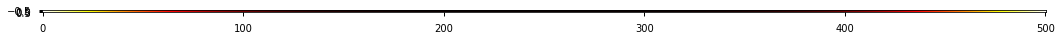

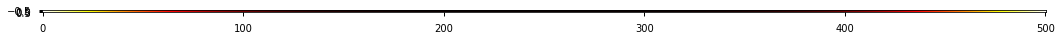

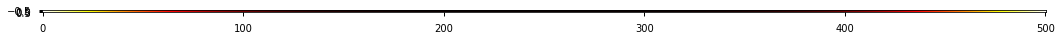

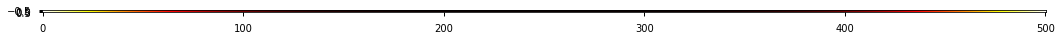

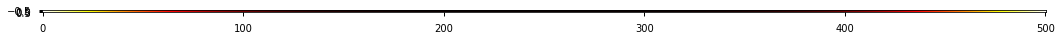

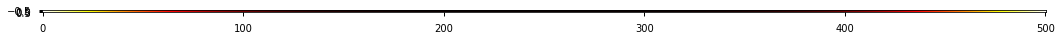

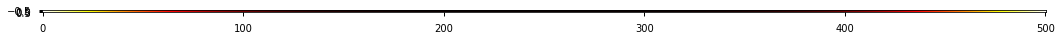

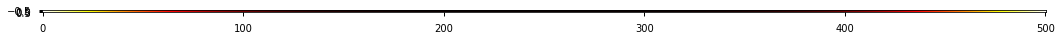

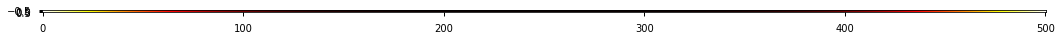

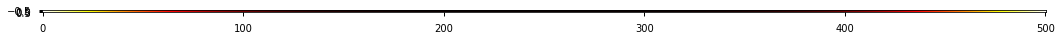

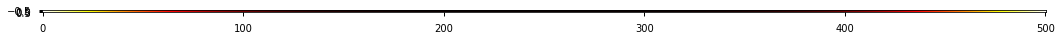

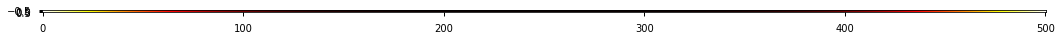

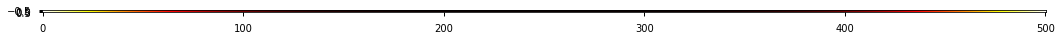

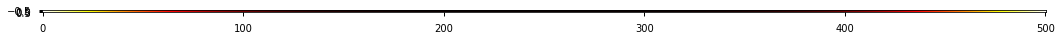

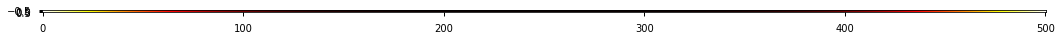

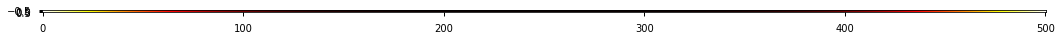

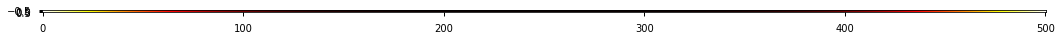

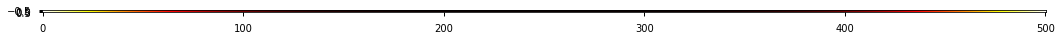

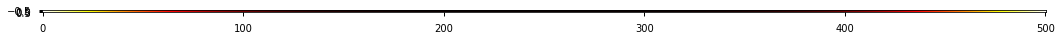

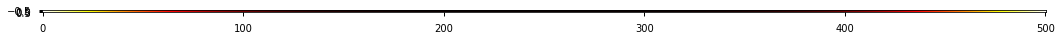

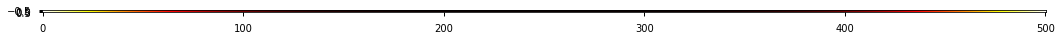

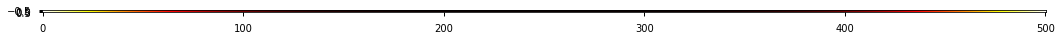

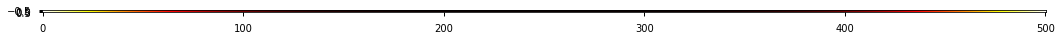

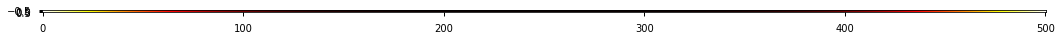

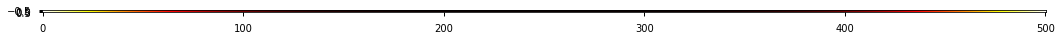

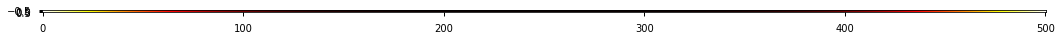

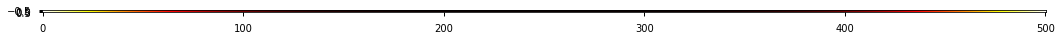

Error in callback <function flush_figures at 0x7f659d754200> (for post_execute):


KeyboardInterrupt: ignored

In [28]:
for i in range(len(u)):
    plt.figure(figsize=(18, 5))
    im = u[i][np.newaxis,:]
    plt.imshow(im,cmap='hot')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.1)

**Answer** - 

### c)

**Use `numba.cuda` to parallelise your implementation on a GPU**.
You should think carefully about when data needs to be copied, and be careful not to copy data to/from the GPU when not needed.

In [ ]:
import numba
from numba import cuda
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-424ded03-b6b4-852d-14cb-aee54555635c
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [ ]:
#Using blocks of SX x SY threads
SX = 16 
SY = 3

In [ ]:
@cuda.jit
def solve_heat_cuda(N,tmax,u):
  #Update the points in the rod excluding the end points

  #Loop through times
  for j in numba.prange((N+1)*tmax-1):
    #Update the positions
    u[j+1,1:N] = u[j,1:N] + (u[j,0:N-1] - 2*u[j,1:N] + u[j,2:N+1])* N/1000

In [ ]:
N = 500
tmax = 10

#Create the rod and set the ends to a constant temperature
u = np.zeros(((N+1)*tmax,N+1))
u[:,0] = 10
u[:,-1] = 10

nblocks = (u.shape[0] + SX - 1) // SX
solve_heat_cuda[(nblocks, 1), (SX, SY)](N, tmax, u.astype('float32'))

NameError: ignored

### d)

**Use your code to estimate the time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8**.
**Briefly (2-3 sentences) describe how you estimated this time**. You may choose to use a plot or diagram to aid your description,
but it is not essential to include a plot.

In [ ]:
N = 400
tmax = 450

#Create the rod and set the ends to a constant temperature
u = np.zeros(((N+1)*tmax,N+1))
u[:,0] = 10
u[:,-1] = 10

solve_heat(N,tmax,u)

We can run up to a large enough $t_{max}$ and find the time value at which the midpoint temperature becomes greater than 9.8

In [ ]:
def find_time(u,T):

  N = u.shape[1] - 1

  mid_points = u[:,int((N+1)/2)]

  try:
    time = np.asarray(mid_points > 9.8).nonzero()[0][0]/(N+1)
    print(f"Mid point temperature > 9.8 found at t = {time}")
    return time
    
  except:
    print("Mid point temperature > 9.8 not found")

In [ ]:
time = find_time(u,9.8)

Mid point temperature > 9.8 found at t = 419.79551122194516


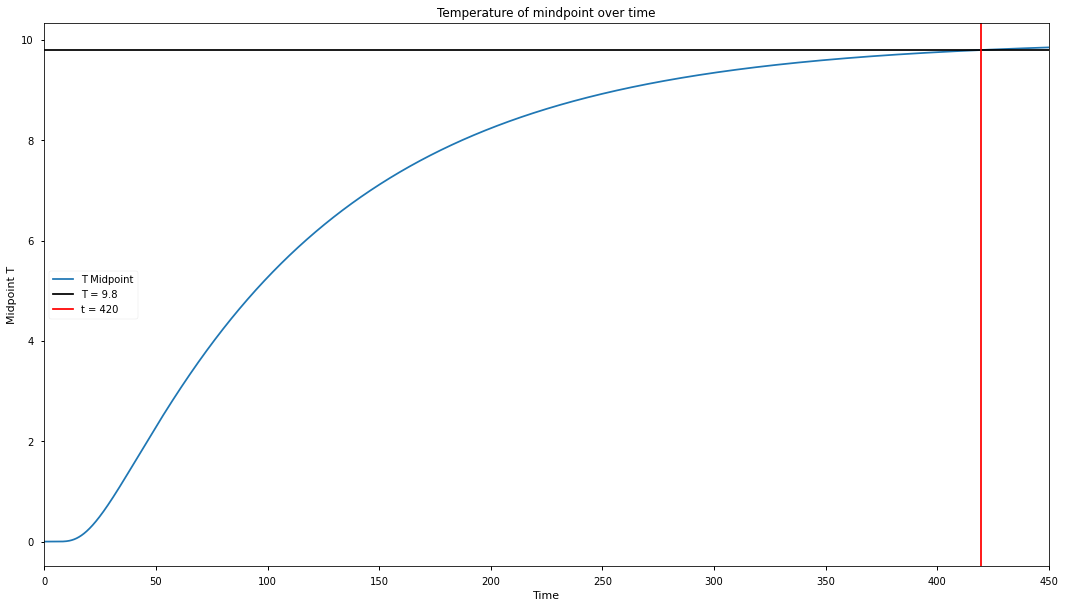

In [ ]:
fig, ax = plt.subplots(1,figsize=(18, 10))

ax.plot(np.linspace(0,tmax,(N+1)*tmax),u[:,int((N+1)/2)],label = 'T Midpoint')
ax.set_ylabel("Midpoint T")
ax.set_xlabel("Time")
ax.set_title("Temperature of mindpoint over time")
ax.set_xlim([0,tmax])
ax.axhline(9.8,c='black',label = 'T = 9.8')
ax.axvline(time,c='red',label = f't = {time:0.0f}')
ax.legend();